<a href="https://colab.research.google.com/github/DuncanFerguson/GITHUB_REPOSITORY/blob/main/Machine_Learning%5CMachineLab_5_Duncan_Ferguson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5
Student: Duncan Ferguson
<br> Class: COMP-4432-1
<br> Date: 7/28/2022




In [398]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Import Strings
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans


# 1. Create a data preprocessing pipeline using scikit-learn

- Combine the data preprocessing and model creation steps from project 1 into a separate pipeline for each of the three algorithms I compared.

- Verify these piplines perform the same as the preprocessing and fitting steps when I executed them individually by making sure the performance metrics on the training and test data match.


## Experiment Objective: 
- Did a client subscribe a term deposit. How do we model this.
- What are the significant factors in determining if a client is subscribed to a term deposit



The Data is being downloaded directly from an archive using !wget from google colab. This will grab the data straight from the source and place it straight on your G-drive. URL below.
<br>https://archive.ics.uci.edu/ml/datasets/bank+marketing



In [399]:
# Grabbing the website
!wget 'banking_data' 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'

--2022-07-25 09:50:10--  http://banking_data/
Resolving banking_data (banking_data)... failed: Name or service not known.
wget: unable to resolve host address ‘banking_data’
--2022-07-25 09:50:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip.10’

bank.zip.10         100%[===================>] 565.47K   729KB/s    in 0.8s    

2022-07-25 09:50:12 (729 KB/s) - ‘bank.zip.10’ saved [579043/579043]

FINISHED --2022-07-25 09:50:12--
Total wall clock time: 1.4s
Downloaded: 1 files, 565K in 0.8s (729 KB/s)


In [400]:
# Unzipping the file
!unzip -o 'bank.zip'

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [401]:
# Downloading the Excel file and reading in the second sheet
df = pd.read_csv('bank-full.csv', sep=';')

In [402]:
# Filtering out clients that have been contacted by previous campaigns
df = df.loc[(df['pdays'] == -1) & (df['previous'] == 0)]

# Dropping out these two columns because they are no longer needed
df = df.drop(labels=['pdays','previous'], axis=1)

# Replacing all the Unknown values with Nan
df.replace('unknown', np.nan, inplace=True)

In [403]:
# Displaying the Head of the Data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,NaN,no


# Project 01 Data Preprocessing
- Below is the data preprocessing that was used. I have left this in so that I can compare it later.

In [404]:
# Displaing the Percentage of missing data per column in decimal form
missing_col_per = pd.DataFrame([(df[col].isnull().sum()/df.shape[0]) for col in df.columns] , df.columns, columns=['Percent_Missing'])
missing_col_per

,Percent_Missing
age,0.000000
job,0.006900
marital,0.000000
education,0.041511
default,0.000000
balance,0.000000
housing,0.000000
loan,0.000000
contact,0.350436
day,0.000000


Since we removed all the clients that had been placed in a campaign before we now get 100% of the Poutcome column as unknown. Meaning that this column can be dropped. Below we set up the threshold for dropping a column as over 80% missing. This will end up taking contact and poutcome out of the equation.

In [405]:
# Setting the limit for dropping
drop_lim = df.shape[0] * .8
df_1 = df.dropna(thresh=drop_lim, axis=1)

In [406]:
# Counting to see how many columns have NaN values
print("# Columns w/ NaN", df_1.isnull().any().sum())
display(df_1.isna().sum())

# Columns w/ NaN 2


age             0
job           255
marital         0
education    1534
default         0
balance         0
housing         0
loan            0
day             0
month           0
duration        0
campaign        0
y               0
dtype: int64

In [407]:
# Imputing the value for the educational missing values
df_2 = df_1.copy()

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer = imputer.fit(df_1.loc[:, df_1.columns == 'education'])
new_education = imputer.transform(df_1.loc[:, df_1.columns == 'education'])

# Replacing education with the newly imputed values
df_2['education'] = new_education.tolist()

Now that the values have been imputed for education. I will just drop the rest  of rows that possess NaN values. These only exist in the job column.

In [408]:
# Simple Drop of NaN rows
df_2 = df_1.dropna()
df_2 = df_2.copy()
print('# Columns w/ Nan')
df_2.isnull().any().sum()

# Columns w/ Nan


0

In [409]:
df_2['job'].isnull().sum()

0

Note that only two columns had any NaNs those rows have been dealt with we will consider df_2 the main data frame.

There are three different columns that have two classiciations. These are default, housing, loan, and of course Y. We can turn all of theses in to binary. I will also map all the other categorical variables to integer values.

In [410]:
# Cleanding up some values to make coding better
df_2['job'] = df_2['job'].replace(['blue-collar'], 'blue_collar')
df_2['job'] = df_2['job'].replace(['self-employed'], 'self_employed')
df_2['job'] = df_2['job'].replace(['admin.'], 'admin')

In [411]:
# Gathering the different columns that are objects
obj_cols = [col for col in df_2 if df_2[col].dtype == 'object']

# Mapping the respective columns to binary
df_2['y'] = df_2.y.map(dict(yes=1, no=0))
df_2['default'] = df_2.default.map(dict(yes=1, no=0))
df_2['loan'] = df_2.loan.map(dict(yes=1, no=0))

# Also mapping the different categorical variables
df_2['education'] = df_2.education.map(dict(primary=0, secondary=1, tertiary=2))
df_2['housing'] = df_2.housing.map(dict(no=0, yes=1))
df_2['job'] = df_2.job.map(dict(admin=11, blue_collar=1, entrepreneur=2,
                                housemaid=3, management=4, retired=5,
                                self_employed=6, services=7, student=8,
                                technician=9, unemployed=10))
df_2['marital'] = df_2.marital.map(dict(divorced=0, married=1, single=2))

df_2['month'] = df_2.month.map(dict(jan=1, feb=2,mar=3, apr=4,
                                    may=5, jun=6, jul=7, aug=8, sep=9,
                                    oct=10, nov=11, dec=12))

# Displaying the transformation
df_2.head(20)

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,5,5,261,1,0
1,44,9,2,1,0,29,1,0,5,5,151,1,0
2,33,2,1,1,0,2,1,1,5,5,76,1,0
5,35,4,1,2,0,231,1,0,5,5,139,1,0
6,28,4,2,2,0,447,1,1,5,5,217,1,0
7,42,2,0,2,1,2,1,0,5,5,380,1,0
8,58,5,1,0,0,121,1,0,5,5,50,1,0
9,43,9,2,1,0,593,1,0,5,5,55,1,0
10,41,11,0,1,0,270,1,0,5,5,222,1,0
11,29,11,2,1,0,390,1,0,5,5,137,1,0


Now that I have turned these columns into binary I will cast the objects into categorical variables to help with onehot encoding.

In [412]:
# Casting in to category
for col in df_2.columns:
  if col in obj_cols:
    df_2[col] = df_2[col].astype('category')

# Changing the binary fields into categories to be used in the models later
df_2['y'] = df_2['y'].astype('category')
df_2['loan'] = df_2['loan'].astype('category')
df_2['default'] = df_2['default'].astype('category')

# Displaying the new data types.
df_2.dtypes

age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
day             int64
month        category
duration        int64
campaign        int64
y            category
dtype: object

In [413]:
# Displaying the head of the data
df_2.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,5,5,261,1,0
1,44,9,2,1,0,29,1,0,5,5,151,1,0
2,33,2,1,1,0,2,1,1,5,5,76,1,0
5,35,4,1,2,0,231,1,0,5,5,139,1,0
6,28,4,2,2,0,447,1,1,5,5,217,1,0


Now setting up a data pipeline to transform the data. Both the objects/categories and the integers. Because I plan on doing a bit of feature selection down the line. I will set up a data pipline within a function that is aimed at preprocessing the data. This way if I performa forward of backward selection model it will be easier to edit through.

It should be noted that df_2 is now primed for Decision Trees or Randomforest.
And the function below is set up to scale the data for algorithms such as KNN and Logistic Regression. By using scaled data it will reduce bias.

Additionally the function below switched the data types for y, loan, default to make sure they dont go through unwanted transformations

In [414]:
def transform_df(df):
  """This Function is set up to make it easy to transform the data if different
   columns are missing"""
  
  # Changing the following to int so they dont get dummies
  df['y'] = df['y'].astype('int64')
  df['loan'] = df['loan'].astype('int64')
  df['default'] = df['default'].astype('int64')

  # Gathering Dummies for the 
  df_t = pd.get_dummies(data=df, columns=[col for col in df if df[col].dtype == 'category'])
  
  # Flipping the y, loan, default back to category so they dont get scaled
  df_t['y'] = df_t['y'].astype('category')
  df_t['loan'] = df_t['loan'].astype('category')
  df_t['default'] = df_t['default'].astype('category')

  
  # Scaling all the integer data with the MinMaxScaler()
  scaler = MinMaxScaler()
  s_cols = [col for col in df_t if df_t[col].dtype == 'int64']
  df_t[s_cols] = scaler.fit_transform(df_t[s_cols])


  return df_t

Note that df_3 is a full feature data set. It is just shown below to display that one hot encoding is actually taking place. and that scalling is being conducted.

In [415]:
# Displaying what the newly transformed data looks like
df_3 = transform_df(df_2)
display(df_3.head())
display(df_3.dtypes)

,age,default,balance,loan,day,duration,campaign,y,job_1,job_2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.519481,0,0.092259,0,0.133333,0.053070,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.337662,0,0.073067,0,0.133333,0.030704,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.194805,0,0.072822,1,0.133333,0.015453,0.0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
5,0.220779,0,0.074901,0,0.133333,0.028264,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0.129870,0,0.076862,1,0.133333,0.044124,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


age             float64
default        category
balance         float64
loan           category
day             float64
duration        float64
campaign        float64
y              category
job_1             uint8
job_2             uint8
job_3             uint8
job_4             uint8
job_5             uint8
job_6             uint8
job_7             uint8
job_8             uint8
job_9             uint8
job_10            uint8
job_11            uint8
marital_0         uint8
marital_1         uint8
marital_2         uint8
education_0       uint8
education_1       uint8
education_2       uint8
housing_0         uint8
housing_1         uint8
month_1           uint8
month_2           uint8
month_3           uint8
month_4           uint8
month_5           uint8
month_6           uint8
month_7           uint8
month_8           uint8
month_9           uint8
month_10          uint8
month_11          uint8
month_12          uint8
dtype: object

# Pipelining the Preprocessing
- Below is the code used to make a pipeline to preprocess the data

In [416]:
# Displaying the Head of the Data to show that is is un-altered.
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,NaN,no


In [417]:
# Making a copy of df to be used
df_p = df.copy()

# Dropping columns discovered from Project 1
df_p.drop(columns=['poutcome', 'contact', 'day', 'balance',
                   'education', 'default'], inplace=True)

# Changing the Objects to categories
obj_cols = [col for col in df_p if df_p[col].dtype == 'object']
for col in df_p.columns:
  if col in obj_cols:
    df_p[col] = df_p[col].astype('category')

# Dropping the remaining Nan rows
df_p.dropna(inplace=True)

df_p.info()
# Conducting the first set of transformation to the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36699 entries, 0 to 45209
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       36699 non-null  int64   
 1   job       36699 non-null  category
 2   marital   36699 non-null  category
 3   housing   36699 non-null  category
 4   loan      36699 non-null  category
 5   month     36699 non-null  category
 6   duration  36699 non-null  int64   
 7   campaign  36699 non-null  int64   
 8   y         36699 non-null  category
dtypes: category(6), int64(3)
memory usage: 1.3 MB


In [420]:
# Creating a function for pipeline to be used in KNN
def pipeline_transform_1(df):
  """This function is used to conduct the pipline transformation 
  for KNN & Logistic Regression"""
  # labels = df.columns
  
  # Splitting the classification up in to two
  df_maj = df[df['y'] == 'no']
  df_min = df[df['y'] == 'yes']
  sample_num = len(df_maj)

  # Resampling the data. This is to reproduce results from project 1
  df_min_upsample = resample(df_min, replace=True, n_samples=sample_num, 
                             random_state=42)
  df_b = pd.concat([df_min, df_maj])

  # Setting my X an Y Values
  # x =  df.loc[:, df.columns != 'y']
  # y =  df.loc[:, df.columns == 'y']
  x =  df_b.loc[:, df_b.columns != 'y']
  y =  df_b.loc[:, df_b.columns == 'y']

  # Splitting the data into test and training sets
  x_train, x_test, y_train, y_test = train_test_split(x, y.values.ravel(), 
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y, shuffle=True)

  # Setting up the pipeline to transform the numeric Data
  numFeatures = df.select_dtypes(include=['int64']).columns
  numTransformer = Pipeline(steps=[('minmax', MinMaxScaler())])

  # Setting up the pipeline to transform the Categorical /  Object data
  # This is slightly different from model 1 in the fact that I use onehot over dummies
  catFeatures = df.select_dtypes(include=['category']).drop(['y'], axis=1).columns
  catTransformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                   ('Onehot Encoding', OneHotEncoder(drop='if_binary'))])

  # Setting up a preprocessor
  preprocessor = ColumnTransformer(
            transformers=[('nums', numTransformer, numFeatures),
                          ('cat', catTransformer, catFeatures)])

  pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('Logistic Regression', LogisticRegression(solver='newton-cg', multi_class='multinomial'))])
  model1 = pipeline.fit(x_train, y_train)

  print("The training score was:", round(model1.score(x_train, y_train)*100,2))
  print("The testing score was:", round(model1.score(x_test, y_test)*100,2))
  

In [422]:
# Running Tests on the different Pipelines for the transformation
pipeline_transform_1(df_p)

The training score was: 91.74
The testing score was: 91.12


# 2). Use Nested cross-validation to optimize and compare the performance of the machine learning algorithms you are using to model your data.

- In order to perform a more equal comparison of your models' performance, and to ensure that we have the best set of hyperparameters in use, implement nested cross-validation for each pipeline using the GridSearchCV class and cross_val_score function.

- For each of the pipelines that I am comparing, create a list of values for each applicable hyperparamter and provide it as the param_grid for the GridSearchCV class.

- Compare this nested cross-validation technique to the model comparison I performed in project 1.

- Are my findings different now that the pipelines are tuned and compared in an unbiased manner

## Imbalanced Testing Data

Now that we have a transforming method it is time to start looking at if we have equally weight output labels. We do not. Therefore, the next steps are going to be aimed at evening out this training data set. The method that is used is resampling. This is done by over sampling the with replacement until the client respondants with yes is equal to that of those saying no. (1,0)

In [ ]:
# Showing the imbalance with the classification variable
display(df_3['y'].value_counts())

0    32059
1     3222
Name: y, dtype: int64

In [ ]:
def train_data_w_resample(df):
  """This function is aimed at creating test train that has balanced classes"""
  df_maj = df[df['y'] == 0]
  df_min = df[df['y'] == 1]

  # Finding the number of samples that we need for a 50/50 Split
  sample_num = len(df_maj)

  df_min_upsample = resample(df_min, replace=True, n_samples=sample_num, 
                             random_state=42)

  df_unsampled = pd.concat([df_maj, df_min_upsample])

  return df_unsampled

In [ ]:
def train_data(df):
  """This Function is set up to help make it easier to pass
  different datasets through for training. It also uses 
  resampling"""

  # Dividing up x and y
  X_all = df.loc[:, df.columns != 'y']
  Y_all = df.loc[:, df.columns == 'y']

  # creating a train and test set
  x_train, x_test, y_train, y_test = train_test_split(
      X_all, Y_all, test_size=0.2, random_state=42, stratify=Y_all, shuffle=True)
  
  # Back up line incase I need to turn y into an array
  # X_all, Y_all.values.ravel(), test_size=0.2, random_state=42, stratify=Y_all)
  
  return x_train, x_test, y_train, y_test

In [ ]:
# Showing a test of training df_3
x_train_1, x_test_1, y_train_1, y_test_1 = train_data(df_3)
y_train_1.value_counts()

y
0    25646
1     2578
dtype: int64

In [ ]:
# Sending off the x and y training samples to get resampled
df_train = pd.concat([x_train_1.reset_index(drop=True), y_train_1.reset_index(drop=True)], axis=1)
train_resampled = train_data_w_resample(df_train)

# Splitting the data back up in to the test and training sample for
# The models to be used later
x_train_re = train_resampled.loc[:, train_resampled.columns != 'y']
y_train_re = train_resampled.loc[:, train_resampled.columns == 'y']

In [ ]:
# Showing how the data has now been resampled to create equal outputs
y_train_re.value_counts()

y
0    25646
1    25646
dtype: int64

## Feature Selection Analysis
One of the requirements is to perform some feature selection. Below are a few methods that are used for determining the feature select.

I will use the random forest for features selection. Because Random forest does not need one hote encoded or scaled data I will use. df_2. Random Forest does not perform well with unbalanced data. Therefore I will use the training test balancing above. df_3 is actually a fully one hot encoded and scaled. Where df_2 has numeric label encoding, but has not been scaled or one hot encoded.

In [ ]:
# Creating Balanced Training set of DF_2
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_data(df_2)
df_rf_train = pd.concat([x_train_rf.reset_index(drop=True), y_train_rf.reset_index(drop=True)], axis=1)
train_rf_resampled = train_data_w_resample(df_rf_train)
x_train_rf_re = train_rf_resampled.loc[:, train_rf_resampled.columns != 'y']
y_train_rf_re = train_rf_resampled.loc[:, train_rf_resampled.columns == 'y']

In [ ]:
# Note that this code closely follows the book Random forest feature selection

# Gathering Labels
rf_labels = train_rf_resampled.columns[1:]

# Creating the RandomForest with 500 estimators
forest = RandomForestClassifier(n_estimators=500, random_state=42)

# Training the model
forest.fit(x_train_rf_re, y_train_rf_re.values.ravel())

# Gathering the importances
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Printing the Results
for f in range(x_train_rf_re.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, rf_labels[indices[f]], importances[indices[f]]))

 1) campaign                       0.453697
 2) duration                       0.098869
 3) housing                        0.096995
 4) job                            0.095857
 5) month                          0.088555
 6) marital                        0.040854
 7) y                              0.038455
 8) loan                           0.036382
 9) default                        0.019754
10) education                      0.018124
11) day                            0.010853
12) balance                        0.001606


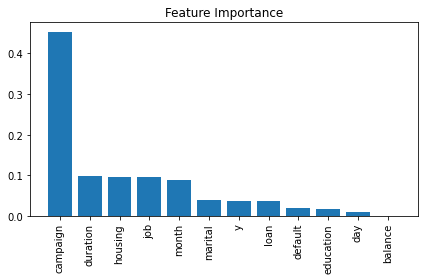

In [ ]:
# Graphing the Feature Importance
plt.title("Feature Importance")
plt.bar(range(x_train_rf_re.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train_rf_re.shape[1]), rf_labels[indices], rotation=90)
plt.xlim(-1, x_train_rf_re.shape[1])
plt.tight_layout()

After looking at the feature imporance for y. It becomes apparent that
we can drop balance, day, eduction, loan, default. Educationally especially
because we imputed certain values. These are surprising results for seeing that balance is not a factor. On the other side it is not surprising to see that day is not a factor. It is also surprising to see that loan and default are not higher factors, but that the campaign and the duration are actually big contributing factors.

The next bit of code will be removing these variables for df_4. I will also make a training set that has one hot encoding for the remaining models.


In [ ]:
df_4 = df_2.drop(['day', 'balance', 'education', 'default'], axis=1).copy()
df_4.head()

,age,job,marital,housing,loan,month,duration,campaign,y
0,58,4,1,1,0,5,261,1,0
1,44,9,2,1,0,5,151,1,0
2,33,2,1,1,1,5,76,1,0
5,35,4,1,1,0,5,139,1,0
6,28,4,2,1,1,5,217,1,0


In [ ]:
# Creating Balanced Training set of DF_4
# Also creating a one hot encoding
x_train_fs, x_test_fs, y_train_fs, y_test_fs = train_data(df_4)
df_fs_train = pd.concat([x_train_fs.reset_index(drop=True), y_train_fs.reset_index(drop=True)], axis=1)
train_fs_resampled = train_data_w_resample(df_fs_train)
x_train_fs_re = train_fs_resampled.loc[:, train_fs_resampled.columns != 'y']
y_train_fs_re = train_fs_resampled.loc[:, train_fs_resampled.columns == 'y']

# 3). Create a confusion matric

- Create a confusion matrix showing the TP, FP, TN, and FN values for each of the three optimized pipelines that were created using nested cross validation in step 2.

- Visualize the confusion matrix using a similar technique to the on e that was used in the ch06 example

## Model 1: Logistic Regression

In [ ]:
# Model Code 1: Logistic Regression
logistic_eval = Pipeline(steps=[('classifier', LogisticRegression(solver='newton-cg', multi_class='multinomial'))])
logistic_eval.fit(x_train_fs_re, y_train_fs_re.values.ravel())

# Printing the accuracy of the test
display("Training score:", round(logistic_eval.score(x_train_fs_re, y_train_fs_re)*100,2))
display("Testing score:", round(logistic_eval.score(x_test_fs, y_test_fs)*100,2))

'Training score:'

79.65

'Testing score:'

81.62

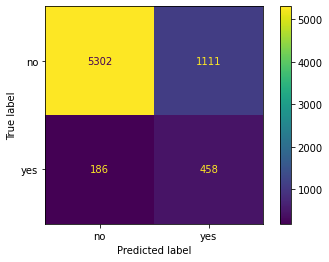

In [ ]:
#  Creating Predictions for the logistic regression
y_logistic_pred = logistic_eval.predict(x_test_fs)

# Creating a confusion matrix to look at different Scores
conf_matrix_log = confusion_matrix(y_test_fs, y_logistic_pred)

# Displaying the Confusion Matrix
log_labels = ['no','yes']
ConfusionMatrixDisplay(conf_matrix_log, display_labels=log_labels).plot()
plt.show()

In [ ]:
# Computing the precision, recall, and f1 scores for the Logistic Regresion
display("Precision Score: ", precision_score(y_true=y_test_fs, y_pred=y_logistic_pred))
display("Recall Score: ", recall_score(y_true=y_test_fs, y_pred=y_logistic_pred))
display("F1 Score:", f1_score(y_true=y_test_fs, y_pred=y_logistic_pred))

'Precision Score: '

0.29190567240280435

'Recall Score: '

0.7111801242236024

'F1 Score:'

0.4139177586985992

## Model 2: K-Nearest Neighbour

To start the K-Nearest Neighbour I will use K means to determine where the elbow is to figure out how many clusters I want to use. It is a bit crude, but better than just guessing.

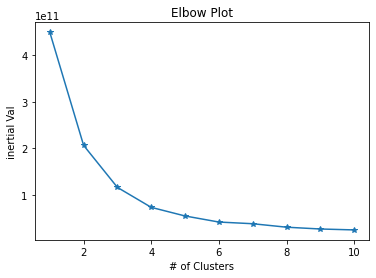

In [ ]:
# Using the Elbow Method for determining the Number of Clusters
kmeans_kwargs = {"init":"random", "n_init": x_train_rf_re.shape[1], "max_iter":500, "random_state":42}

# Setting up lists to hold the SS Values
# Setting up a list to hold SSE Values
clusters = []
inertia_vals = []

# Looping through the different amounts of values
for k in range(1,11):
    km = KMeans(n_clusters=k, **kmeans_kwargs)
    km.fit(x_train_rf_re)
    clusters.append(km.inertia_)

    # Appending model to cluster list
    clusters.append(km)
    inertia_vals.append(km.inertia_)

# plot the inertia vs K values
plt.plot(range(1,11), inertia_vals, marker='*')
plt.xlabel('# of Clusters')
plt.ylabel('inertial Val')
plt.title('Elbow Plot')
plt.show()

The Elbow looks to be at 4 clusters.

In [ ]:
# Model Code 2: K-Nearest Neighbour
knn_classifier = KNeighborsClassifier(n_neighbors=4)
knn_classifier.fit(x_train_fs_re, y_train_fs_re.values.ravel())

# Printing the accuracy of the test
display("Training score:", round(knn_classifier.score(x_train_fs_re, y_train_fs_re)*100,2))
display("Testing score:", round(knn_classifier.score(x_test_fs, y_test_fs)*100,2))

'Training score:'

96.88

'Testing score:'

84.67

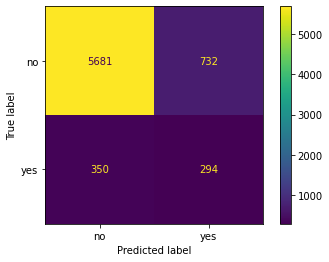

In [ ]:
#  Creating Predictions for the logistic regression
y_knn_pred = knn_classifier.predict(x_test_fs)

# Creating a confusion matrix to look at different Scores
conf_matrix_knn = confusion_matrix(y_test_fs, y_knn_pred)

# Displaying the Confusion Matrix
log_labels = ['no','yes']
ConfusionMatrixDisplay(conf_matrix_knn, display_labels=log_labels).plot()
plt.show()

In [ ]:
# Computing the precision, recall, and f1 scores for the KNN
display("Precision Score: ", precision_score(y_true=y_test_fs, y_pred=y_knn_pred))
display("Recall Score: ", recall_score(y_true=y_test_fs, y_pred=y_knn_pred))
display("F1 Score:", f1_score(y_true=y_test_fs, y_pred=y_knn_pred))

'Precision Score: '

0.28654970760233917

'Recall Score: '

0.45652173913043476

'F1 Score:'

0.35209580838323357

## Model 3: Decision Tree

It must be noted that for the decision tree I use the same training and testing that the random rain forrest did above. The reason for this was to not enclude scaling or one hot encoding. 

In [ ]:
# Model Code 3: Decision Tree
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=42)
tree_model.fit(x_train_rf_re, y_train_rf_re)

# Printing the accuracy of the test
display("Training score:", round(tree_model.score(x_train_rf_re, y_train_rf_re)*100,2))
display("Testing score:", round(tree_model.score(x_test_rf, y_test_rf)*100,2))

'Training score:'

85.54

'Testing score:'

82.17

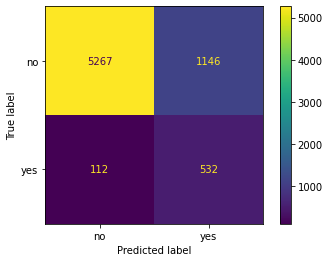

In [ ]:
#  Creating Predictions for the logistic regression
y_tree_pred = tree_model.predict(x_test_rf)

# Creating a confusion matrix to look at different Scores
conf_matrix_tree = confusion_matrix(y_test_rf, y_tree_pred)

# Displaying the Confusion Matrix
log_labels = ['no','yes']
ConfusionMatrixDisplay(conf_matrix_tree, display_labels=log_labels).plot()
plt.show()

In [ ]:
# Computing the precision, recall, and f1 scores for the Decision Tree
display("Precision Score: ", precision_score(y_true=y_test_rf, y_pred=y_tree_pred))
display("Recall Score: ", recall_score(y_true=y_test_rf, y_pred=y_tree_pred))
display("F1 Score:", f1_score(y_true=y_test_rf, y_pred=y_tree_pred))

'Precision Score: '

0.3170441001191895

'Recall Score: '

0.8260869565217391

'F1 Score:'

0.458225667527993

# 4). Creat a MajorityVoteClassifer instance from the algorithms I've chosen to see if an ensemble can outperform the individual algorithms

- Now that we better understand how each of the models perform individually, let's creat an ensemble to see if they work better together

- Using the MajorityVoteClassifier class that was created in the ch07 example Juypter Note book, create an ensemble using the three pipelines I created in step 1.

- Use 10-fold cross validation to compute the score of the ensemble, as well as each pipeline individually.

- Compare the performance of the ensemble to the individual models

- Does the ensemble outperform the models?

- Note: While we used ROC AUC scores in class, that was for binary classification only. Thankfully that is the classification that was used.